In [1]:
import pandas as pd

# Load the Excel file
excel_file = 'invoice_20241201.xlsx'

# Read the first sheet (or specify the sheet name or index if needed)
data = pd.read_excel(excel_file, sheet_name='Sheet1')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud
import jieba  # For Chinese text segmentation
import re  # For cleaning text
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.stats import linregress
import seaborn as sns

In [3]:
# Specify the font file path for Chinese characters
font_path = '/System/Library/Fonts/PingFang.ttc'  # Adjust to the actual path
font_prop = FontProperties(fname=font_path)

In [33]:
data.head()

,customer_id,inovice_no,item_name,Item_category,channel,amount,seller_ban,inv_date,unit_price,quantity,customer_category,lancome,has_discount,粉底,精華液,seller_name,seller_name_adjusted,potential_score,Item_category_new
0,U0001,V000001,Websites Marketing Premium vNext Intl - Rene...,手續費‧服務費‧禮券,電子商務‧直銷,576,73672692,2024-04-24,576,1,2,0,1,NaN,NaN,ＧｏＤａｄｄｙ．ｃｏｍ， ＬＬＣ,ＧｏＤａｄｄｙ．ｃｏｍ， ＬＬＣ,NaN,手續費‧服務費‧禮券
1,U0002,V000002,來復易紙尿片,親子‧女性,日常用品‧百貨,225,90513776,2024-04-06,225,1,3,0,0,NaN,NaN,全聯實業股份有限公司大肚中蔗分公司,全聯實業,2.0,親子‧女性
2,U0003,V000003,熊寶貝護衣海洋,親子‧女性,日常用品‧百貨,129,24802613,2024-04-06,129,1,3,0,0,NaN,NaN,全聯實業股份有限公司潮州光復分公司,全聯實業,1.0,親子‧女性
3,U0005,V000005,熊寶貝護衣小蒼,親子‧女性,日常用品‧百貨,792,24794971,2024-04-04,198,4,3,0,0,NaN,NaN,全聯實業股份有限公司大里新芳分公司,全聯實業,3.0,親子‧女性
4,U0006,V000006,蘇菲天然棉護墊,親子‧女性,日常用品‧百貨,140,90303384,2024-04-06,70,2,2,0,0,NaN,NaN,全聯實業股份有限公司竹北文平分公司,全聯實業,NaN,親子‧女性


#### 活躍客美妝保養平均佔比
以此作為 benchmark（每位顧客應達到的美妝消費水準)

In [4]:
# Step 1: Filter the data for 活躍客
filtered_data = data[data['customer_category'] == 2]

# Step 2: Calculate total amount and '美妝‧保養' amount for each customer
total_amount = filtered_data.groupby('customer_id')['amount'].sum()
beauty_amount = filtered_data[filtered_data['Item_category'] == '美妝‧保養'].groupby('customer_id')['amount'].sum()

# Step 3: Calculate the ratio of '美妝‧保養' amount to total amount
ratios = (beauty_amount / total_amount).fillna(0)

# Step 4: Compute the average ratio（活躍客美妝保養佔比）
average_active_beauty_ratio = ratios.mean()

print(f"Average ratio of '美妝‧保養' amount to total amount for customer_category = 2: {average_active_beauty_ratio:.2f}")

Average ratio of '美妝‧保養' amount to total amount for customer_category = 2: 0.23


#### 沈睡客美妝保養平均佔比

In [5]:
# Step 1: Filter the data for customer_category = 3
filtered_data = data[data['customer_category'] == 3]

# Step 2: Calculate total amount and '美妝‧保養' amount for each customer
total_amount = filtered_data.groupby('customer_id')['amount'].sum()
beauty_amount = filtered_data[filtered_data['Item_category'] == '美妝‧保養'].groupby('customer_id')['amount'].sum()

# Step 3: Calculate the ratio of '美妝‧保養' amount to total amount
ratios = (beauty_amount / total_amount).fillna(0)

# Step 4: Compute the average ratio
average_sleep_beauty_ratio = ratios.mean()

print(f"Average ratio of '美妝‧保養' amount to total amount for customer_category = 2: {average_sleep_beauty_ratio:.2f}")

Average ratio of '美妝‧保養' amount to total amount for customer_category = 2: 0.19


## 潛力分群新增欄位

#### 新增 ``beauty_amount_ratio`` 欄位
每位顧客美妝保養消費占比

In [6]:
# Step 1: Calculate total amount and '美妝‧保養' amount for each customer
total_amount = data.groupby('customer_id')['amount'].sum()
beauty_amount = data[data['Item_category'] == '美妝‧保養'].groupby('customer_id')['amount'].sum()

# Step 2: Calculate the ratio of '美妝‧保養' amount to total amount
ratios = (beauty_amount / total_amount).fillna(0)

# Step 3: Map the ratios back to the original DataFrame
data['beauty_amount_ratio'] = data['customer_id'].map(ratios)

# Display the resulting DataFrame
print(data.head())

  customer_id inovice_no                                          item_name  \
0       U0001    V000001  Websites   Marketing Premium vNext Intl - Rene...   
1       U0002    V000002                                             來復易紙尿片   
2       U0003    V000003                                            熊寶貝護衣海洋   
3       U0005    V000005                                            熊寶貝護衣小蒼   
4       U0006    V000006                                            蘇菲天然棉護墊   

  Item_category  channel  amount  seller_ban   inv_date  unit_price  quantity  \
0    手續費‧服務費‧禮券  電子商務‧直銷     576    73672692 2024-04-24         576         1   
1         親子‧女性  日常用品‧百貨     225    90513776 2024-04-06         225         1   
2         親子‧女性  日常用品‧百貨     129    24802613 2024-04-06         129         1   
3         親子‧女性  日常用品‧百貨     792    24794971 2024-04-04         198         4   
4         親子‧女性  日常用品‧百貨     140    90303384 2024-04-06          70         2   

   customer_category  lancome  has_dis

#### 新增 ``beauty_ratio_gap`` 欄位
每位顧客美妝保養消費占比，與活躍客美妝保養消費占比的差距（%）

In [7]:
data['beauty_ratio_gap'] = average_active_beauty_ratio - data['beauty_amount_ratio'] 
print(data.head())

  customer_id inovice_no                                          item_name  \
0       U0001    V000001  Websites   Marketing Premium vNext Intl - Rene...   
1       U0002    V000002                                             來復易紙尿片   
2       U0003    V000003                                            熊寶貝護衣海洋   
3       U0005    V000005                                            熊寶貝護衣小蒼   
4       U0006    V000006                                            蘇菲天然棉護墊   

  Item_category  channel  amount  seller_ban   inv_date  unit_price  quantity  \
0    手續費‧服務費‧禮券  電子商務‧直銷     576    73672692 2024-04-24         576         1   
1         親子‧女性  日常用品‧百貨     225    90513776 2024-04-06         225         1   
2         親子‧女性  日常用品‧百貨     129    24802613 2024-04-06         129         1   
3         親子‧女性  日常用品‧百貨     792    24794971 2024-04-04         198         4   
4         親子‧女性  日常用品‧百貨     140    90303384 2024-04-06          70         2   

   ...  lancome  has_discount  粉底  精華液

#### 新增 ``total_amount`` 欄位
每位顧客整體消費占比

In [8]:
# Step 1: Calculate total amount for each customer
customer_total_amount = data.groupby('customer_id')['amount'].sum()

# Step 2: Map the total amount back to sleep_data
data['total_amount'] = data['customer_id'].map(customer_total_amount)

# Display the updated DataFrame
print(data.head())

  customer_id inovice_no                                          item_name  \
0       U0001    V000001  Websites   Marketing Premium vNext Intl - Rene...   
1       U0002    V000002                                             來復易紙尿片   
2       U0003    V000003                                            熊寶貝護衣海洋   
3       U0005    V000005                                            熊寶貝護衣小蒼   
4       U0006    V000006                                            蘇菲天然棉護墊   

  Item_category  channel  amount  seller_ban   inv_date  unit_price  quantity  \
0    手續費‧服務費‧禮券  電子商務‧直銷     576    73672692 2024-04-24         576         1   
1         親子‧女性  日常用品‧百貨     225    90513776 2024-04-06         225         1   
2         親子‧女性  日常用品‧百貨     129    24802613 2024-04-06         129         1   
3         親子‧女性  日常用品‧百貨     792    24794971 2024-04-04         198         4   
4         親子‧女性  日常用品‧百貨     140    90303384 2024-04-06          70         2   

   ...  has_discount  粉底  精華液        s

#### 新增 ``beauty_amount_gap`` 欄位
每位顧客美妝保養消費可提升空間（$）

In [9]:
# Step 1: Calculate total amount for each customer
data['beauty_amount_gap'] = data['beauty_ratio_gap'] * data['total_amount']

# Display the updated DataFrame
print(data.head())

  customer_id inovice_no                                          item_name  \
0       U0001    V000001  Websites   Marketing Premium vNext Intl - Rene...   
1       U0002    V000002                                             來復易紙尿片   
2       U0003    V000003                                            熊寶貝護衣海洋   
3       U0005    V000005                                            熊寶貝護衣小蒼   
4       U0006    V000006                                            蘇菲天然棉護墊   

  Item_category  channel  amount  seller_ban   inv_date  unit_price  quantity  \
0    手續費‧服務費‧禮券  電子商務‧直銷     576    73672692 2024-04-24         576         1   
1         親子‧女性  日常用品‧百貨     225    90513776 2024-04-06         225         1   
2         親子‧女性  日常用品‧百貨     129    24802613 2024-04-06         129         1   
3         親子‧女性  日常用品‧百貨     792    24794971 2024-04-04         198         4   
4         親子‧女性  日常用品‧百貨     140    90303384 2024-04-06          70         2   

   ...  粉底  精華液        seller_name  se

## 潛力分群
已先根據在蘭蔻內部消費記錄，區分為「新客」、「活躍客」、「沈睡客」，並貼標

In [10]:
new_data = data[data['customer_category'] == 1]
active_data = data[data['customer_category'] == 2]
sleep_data = data[data['customer_category'] == 3]

In [11]:
new_data_unique = new_data.drop_duplicates(subset=['customer_id'])
active_data_unique = active_data.drop_duplicates(subset=['customer_id'])
sleep_data_unique = sleep_data.drop_duplicates(subset=['customer_id'])

#### 新客、活躍客、沈睡客 ``美妝保養消費可提升金額`` 分佈圖（``beauty_amount_gap``）

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


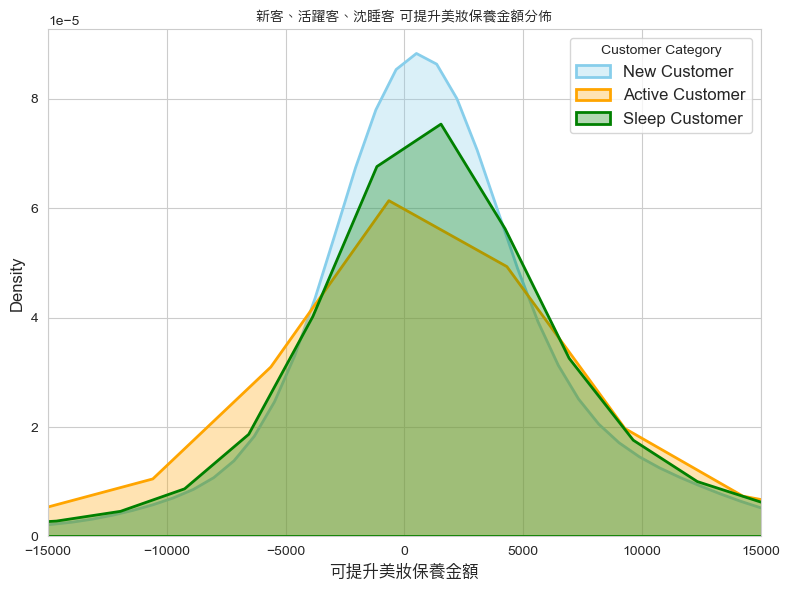

In [12]:
# Set the plot size and style
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Plot smooth density curves for new_data
sns.kdeplot(new_data_unique['beauty_amount_gap'], 
            fill=True, 
            color='skyblue', 
            label='New Customer', 
            alpha=0.3,  # Lower transparency to reduce overlap
            linewidth=2)

# Plot smooth density curves for active_data
sns.kdeplot(active_data_unique['beauty_amount_gap'], 
            fill=True, 
            color='orange', 
            label='Active Customer', 
            alpha=0.3,  # Lower transparency
            linewidth=2)

# Plot smooth density curves for sleep_data
sns.kdeplot(sleep_data_unique['beauty_amount_gap'], 
            fill=True, 
            color='green', 
            label='Sleep Customer', 
            alpha=0.3,  # Lower transparency
            linewidth=2)

# Customize the plot
plt.title('新客、活躍客、沈睡客 可提升美妝保養金額分佈', fontsize=16,fontproperties=font_prop)
plt.xlabel('可提升美妝保養金額', fontsize=12,fontproperties=font_prop)
plt.ylabel('Density', fontsize=12)

# Add x-axis limit
plt.xlim(-15000, 15000)

# Add a legend
plt.legend(title='Customer Category', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


#### 各客群``美妝保養消費可提升金額`` 各百分位數（``beauty_amount_gap``）
以沈睡客可提升美妝保養金額為最高

In [20]:
data_unique = data.drop_duplicates(subset=['customer_id'])

In [61]:
new_percentiles = new_data_unique['beauty_amount_gap'].quantile([0, 0.25, 0.5, 0.75, 1])
active_percentiles = active_data_unique['beauty_amount_gap'].quantile([0, 0.25, 0.5, 0.75, 1])
sleep_percentiles = sleep_data_unique['beauty_amount_gap'].quantile([0, 0.25, 0.5, 0.75, 1])

print("new_percentile:",new_percentiles)
print("active_percentile:",active_percentiles)
print("sleep_percentile:",sleep_percentiles)

new_percentile: 0.00    -29306.961708
0.25      -751.849208
0.50       618.222728
0.75      3150.379588
1.00    123327.784651
Name: beauty_amount_gap, dtype: float64
active_percentile: 0.00   -192523.396689
0.25     -1796.642650
0.50       503.428057
0.75      3346.515391
1.00    772677.161938
Name: beauty_amount_gap, dtype: float64
sleep_percentile: 0.00    -91740.594640
0.25      -798.310526
0.50       835.554073
0.75      4070.583152
1.00    426749.937866
Name: beauty_amount_gap, dtype: float64


#### 潛力客群貼標
高潛力（3）：客群內「可提升美妝保養金額」前 25 百分位數
中潛力（2）：客群內「可提升美妝保養金額」> 0
低潛力（1）：客群內「可提升美妝保養金額」< 0

In [62]:
# Add a new column 'potential_score' and default to category 2
data['potential_score'] = 2

# Assign potential_score = 1 for all cases where beauty_amount_gap < 0
data.loc[data['beauty_amount_gap'] < 0, 'potential_score'] = 1

# Assign potential_score = 3 for customer_category = 1 and beauty_amount_gap > 3150
data.loc[(data['customer_category'] == 1) & (data['beauty_amount_gap'] > 3150), 'potential_score'] = 3

# Assign potential_score = 3 for customer_category = 2 and beauty_amount_gap > 3346
data.loc[(data['customer_category'] == 2) & (data['beauty_amount_gap'] > 3346), 'potential_score'] = 3

data.loc[(data['customer_category'] == 3) & (data['beauty_amount_gap'] > 4070), 'potential_score'] = 3

# Check the updated DataFrame
print(data[['customer_category', 'beauty_amount_gap', 'potential_score']].head())

   customer_category  beauty_amount_gap  potential_score
0                  2       13193.669950                3
1                  3          76.194425                2
2                  3       -1018.239514                1
3                  3       31122.002004                3
4                  2      -12217.827826                1
